In [ ]:
# !pip install ipywidgets
# !pip install datasets
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./cats_vs_dogs")
dataset = dataset["train"]
dataset

In [ ]:
dataset = dataset.shuffle(seed=1234).select(range(100)) # 🤔
dataset = dataset.train_test_split(test_size=0.3, seed=1234) # 🤔
dataset

In [ ]:
dataset["train"][0]["image"]

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label

In [ ]:
# !pip install torch torchvision torchaudio
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# !pip install transformers
from transformers import AutoImageProcessor

checkpoint = "microsoft/resnet-50" # 🤔
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
image_processor

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor # 🤔

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"], image_processor.size["width"])
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize]) # 🤔

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

dataset = dataset.with_transform(transforms)
dataset

In [ ]:
dataset["train"][0]["pixel_values"]

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()
data_collator

In [ ]:
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# !pip install accelerate
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

training_args = TrainingArguments(
    output_dir="my_image_model", # 🤔
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch", # 🤔
    learning_rate=1e-5, # 🤔
    per_device_train_batch_size=1, # 🤔
    gradient_accumulation_steps=1, # 🤔
    per_device_eval_batch_size=1, # 🤔
    num_train_epochs=1, # 🤔
    warmup_ratio=0.1, # 🤔
    logging_steps=10, # 🤔
    load_best_model_at_end=True, # 🤔
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("my_final_image_model") # 🤔

In [2]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./cats_vs_dogs")
dataset

Generating train split: 1877 examples [00:00, 14488.22 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1877
    })
})

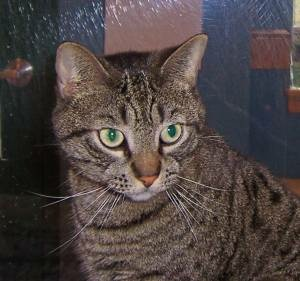

In [3]:
image = dataset["train"]["image"][1] # 🤔
image

In [4]:
from transformers import pipeline

classifier = pipeline("image-classification", model="./my_final_image_model")
classifier(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'dog', 'score': 0.4979545474052429},
 {'label': 'cat', 'score': 0.4891599416732788}]

In [6]:
%%writefile app.py
# !pip install gradio ipywidgets
from transformers import pipeline
import gradio as gr

# "Artifacts"
classifier = pipeline("image-classification", model="./my_final_image_model")

def predict(image):
    y_pred = classifier(image)
    y_pred = {y["label"]: y["score"] for y in y_pred}
    return y_pred

# https://www.gradio.app/guides
with gr.Blocks() as demo:
    image = gr.Image(type="pil")
    predict_btn = gr.Button("Predict", variant="primary")
    output = gr.Label(label="Output")

    inputs = [image]
    outputs = [output]
    
    predict_btn.click(predict, inputs=inputs, outputs=outputs)

if __name__ == "__main__":
    demo.launch() # Local machine only
    # demo.launch(server_name="0.0.0.0") # LAN access to local machine
    # demo.launch(share=True) # Public access to local machine

Overwriting app.py


In [5]:
%run app.py

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
# %%writefile requirements.txt
# torch
# torchvision
# torchaudio
# transformers
# gradio